## 구글 드라이브 연동
- 구글 드라이브와 연동하는 코드를 실행한다. 

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## 라이브러리 불러오기
- 필요한 라이브러리를 불러온다. 

In [45]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
import scipy
import seaborn as sns

print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(statsmodels.__version__)
print(scipy.__version__)
print(sns.__version__)

1.3.5
1.21.6
3.2.2
0.10.2
1.4.1
0.11.2


## 데이터 불러오기
- pandas 옵션 설정을 진행할 수 있다. 

In [4]:
pd.set_option('display.width', 80)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.0f}'.format

In [5]:
# covidtotals = pd.read_csv("data/covidtotalswithmissings.csv")
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2022/Python 데이터 분석 라이브러리_20220423/Basic/Chapter 5. Missing Values & Outliers/'
covidtotals = pd.read_csv(DATA_PATH + "data/covidtotalswithmissings.csv")
covidtotals.set_index("iso_code", inplace=True)

- 사례 열(totvars)과 인구통계 열(demovars)을 만든다.

In [6]:
totvars = ['location','total_cases','total_deaths','total_cases_pm',
  'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita',
  'hosp_beds']

## 결측치 처리
- 인구통계 열에서 누락 데이터를 확인한다. 
    + 우선 열방향으로 누락값의 갯수를 파악한다. 
- 5가지 인구 통계 변수 중 3개가 누락된 곳이 10개국, 4개가 누락된 곳이 8개국이다. 

In [7]:
covidtotals[demovars].isnull().sum(axis=0)
demovarsmisscnt = covidtotals[demovars].isnull().sum(axis=1)
demovarsmisscnt.value_counts()

0    156
1     24
2     12
3     10
4      8
dtype: int64

- 인구통계 데이터가 세 가지 이상 누락된 국가를 나열한다. 
- 처음 5개 국가만 출력한다. 

### Index Alignment 
- 인덱스의 값끼리 연산이 이뤄지는 것을 말함. 

In [8]:
s1 = pd.Series([1, 2, 3, 4], index=['a', 'b', 'c', 'd'])
s2 = pd.Series([4, 3, 2, 1], index=['d', 'c', 'b', 'a'])

s1 + s2

a    2
b    4
c    6
d    8
dtype: int64

In [9]:
covidtotals.loc[demovarsmisscnt>=3, ['location'] + demovars].head(5).T

iso_code,AND,AIA,BES,VGB,FRO
location,Andorra,Anguilla,Bonaire Sint Eustatius and Saba,British Virgin Islands,Faeroe Islands
population,"77,265","15,002","26,221","30,237","48,865"
pop_density,164,NaN,NaN,208,35
median_age,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,NaN,NaN,NaN,NaN,NaN
hosp_beds,NaN,NaN,NaN,NaN,NaN


In [10]:
type(demovarsmisscnt)

pandas.core.series.Series

- 코로나19 사례 데이터에서 누락값을 확인한다. 
- 이 데이터에 대한 누락값이 있는 국가는 한 곳 뿐이다. 

In [11]:
# check the cumulative columns for missing
covidtotals[totvars].isnull().sum(axis=0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [12]:
totvarsmisscnt = covidtotals[totvars].isnull().sum(axis=1)
totvarsmisscnt.value_counts()

0    209
2      1
dtype: int64

In [13]:
covidtotals.loc[totvarsmisscnt>0].T

iso_code,HKG
lastdate,2020-05-26
location,Hong Kong
total_cases,0
total_deaths,0
total_cases_pm,NaN
total_deaths_pm,NaN
population,"7,496,988"
pop_density,"7,040"
median_age,45
gdp_per_capita,"56,055"


- fillna 메서드로 해당 국가의 누락된 사례 데이터를 채운다. 
- 두 경우 모두 분자가 0이므로 값을 0으로 채울수도 있지만

In [14]:
covidtotals.population/1000000

iso_code
AFG   39
ALB    3
DZA   44
AND    0
AGO   33
      ..
VNM   97
ESH    1
YEM   30
ZMB   18
ZWE   15
Name: population, Length: 210, dtype: float64

In [15]:
covidtotals.total_cases/(covidtotals.population/1000000)

iso_code
AFG     391
ALB     395
DZA     214
AND   9,888
AGO       3
       ... 
VNM       3
ESH      39
YEM      11
ZMB      57
ZWE      12
Length: 210, dtype: float64

In [16]:
# use the fillna method to fix the mixing case data
covidtotals.total_cases_pm.fillna(covidtotals.total_cases/
  (covidtotals.population/1000000), inplace=True)

In [17]:
covidtotals.total_deaths_pm.fillna(covidtotals.total_deaths/
  (covidtotals.population/1000000), inplace=True)

In [18]:
covidtotals[totvars].isnull().sum(axis=0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     0
total_deaths_pm    0
dtype: int64

## 변수가 1개인 이상값 식별하기
- 특정 분포의 중심경향성, 퍼진 정도와 형태
- 이상 값 식별시 중요한 건 변수의 분포를 먼저 이해해야 한다. 
    + 정규분포 vs 균등분포

- 데이터 불러오기

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqline
import scipy.stats as scistat

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- 데이터 불러오기

In [21]:
# covidtotals = pd.read_csv("data/covidtotals.csv")
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2022/Python 데이터 분석 라이브러리_20220423/Basic/Chapter 5. Missing Values & Outliers/'
covidtotals = pd.read_csv(DATA_PATH + "data/covidtotals.csv")
covidtotals.set_index("iso_code", inplace=True)

- 컬럼값 비교

In [22]:
totvars = ['location','total_cases','total_deaths','total_cases_pm',
  'total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita',
  'hosp_beds']

- 코로나 19 사례 데이터에 대한 기술 통계량을 구함
- 백분위수 데이터를 표시함. 
    + 왜도와 첨도도 표시
        - 왜도 : 분포가 얼마나 대칭적인지 확인
        - 첨도 : 분포의 꼬리가 얼마나 굵은지를 나타냄 

In [23]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly.describe()

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
count,210,210,210,210
mean,"29,216","1,771","1,355",56
std,"136,398","8,706","2,625",145
min,0,0,0,0
25%,176,4,93,1
50%,"1,242",26,281,6
75%,"10,117",241,"1,801",32
max,"1,790,191","104,383","19,771","1,238"


In [24]:
pd.options.display.float_format = '{:,.2f}'.format
covidtotalsonly.quantile(np.arange(0.0, 1.1, 0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.00,0.00,0.00,0.00,0.00
0.10,22.90,0.00,18.00,0.00
0.20,105.20,2.00,56.29,0.38
0.30,302.00,6.70,115.43,1.72
0.40,762.00,12.00,213.97,3.96
0.50,"1,242.50",25.50,280.93,6.15
0.60,"2,514.60",54.60,543.96,12.25
0.70,"6,959.80",137.20,"1,071.24",25.95
0.80,"16,847.20",323.20,"2,206.30",49.97
0.90,"46,513.10","1,616.90","3,765.14",138.90


In [25]:
covidtotalsonly.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


total_cases       10.80
total_deaths       8.93
total_cases_pm     4.40
total_deaths_pm    4.67
dtype: float64

In [26]:
covidtotalsonly.kurtosis()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


total_cases       134.98
total_deaths       95.74
total_cases_pm     25.24
total_deaths_pm    27.24
dtype: float64

- 정규성 검정 테스트
- p값이 0.05 미만에서 95% 수준에서 정규분포의 귀무가설을 기각할 수 있다. 
    + 귀무가설 : 표본의 모집단이 정규분포를 따른다.
    + 대립가설 : 표본의 모집단이 정규분포를 따르지 않는다. 

In [27]:
# test for normality
def testnorm(var, df):
  stat, p = scistat.shapiro(df[var])
  return p

In [28]:
testnorm("total_cases", covidtotalsonly)

3.753789128593843e-29

In [29]:
testnorm("total_deaths", covidtotalsonly)

4.3427896631016077e-29

In [30]:
testnorm("total_cases_pm", covidtotalsonly)

1.3972683006509067e-23

In [31]:
testnorm("total_deaths_pm", covidtotalsonly)

1.361060423265974e-25

- 모두 정규분포를 따르지 않는다. 

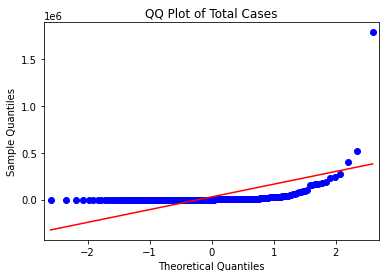

In [32]:
# show a qqplot for total cases and total cases per million
sm.qqplot(covidtotalsonly[['total_cases']]. \
  sort_values(['total_cases']), line='s')
plt.title("QQ Plot of Total Cases")
plt.show()

- 정규성을 이루지 않는다. 직선은 정규분포를 의미하는데, 많은 사례들이 0에 근접하며,오른쪽 끝에서 경사가 급격하게 증가하는 것을 확인할 수 있다. 

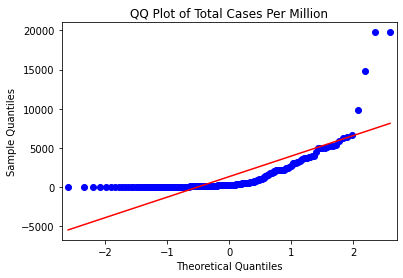

In [33]:
sm.qqplot(covidtotals[['total_cases_pm']]. \
  sort_values(['total_cases_pm']), line='s')
plt.title("QQ Plot of Total Cases Per Million")
plt.show()

- 총확진자 수의 이상값 범위 지정
- 이상값 정의 방법
    + 거리 = 제3사분위 - 제1사분위 
    + 이상값 간주 : > 거리 * 1.5배(+/-)

In [34]:
# show outliers for total cases
thirdq, firstq = covidtotalsonly.total_cases.quantile(0.75), covidtotalsonly.total_cases.quantile(0.25)
interquartilerange = 1.5*(thirdq-firstq)
outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange
print(outlierlow, outlierhigh, sep=" <--> ")

-14736.125 <--> 25028.875


- 여기에서는 양숫값만 가능함

In [38]:
# generate a table of outliers and save it to Excel
def getoutliers():
  dfout = pd.DataFrame(columns=covidtotals.columns, data=None)
  for col in covidtotalsonly.columns[1:]:

    # 3사분위, 1사분위
    thirdq, firstq = covidtotalsonly[col].quantile(0.75), covidtotalsonly[col].quantile(0.25)

    # 3사분위 - 1사분위
    interquartilerange = 1.5*(thirdq-firstq)

    # 이상치의 상한 및 하한 경계값 정하기
    outlierhigh, outlierlow = interquartilerange+thirdq, firstq-interquartilerange

    # 각 데이터 추출
    df = covidtotals.loc[(covidtotals[col]>outlierhigh) | (covidtotals[col]<outlierlow)]

    # 임계치 수준에 검사한 변수를 가리키는 열(varname 추가)
    df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)
    dfout = pd.concat([dfout, df])
  return dfout

outliers = getoutliers()
outliers['varname'].value_counts()
# outliers.to_excel("views/outlierscases.xlsx")

total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: varname, dtype: int64

In [39]:
outliers

,lastdate,location,total_cases,...,varname,threshlow,threshhigh
BGD,2020-06-01,Bangladesh,47153,...,total_cases,"-14,736.12","25,028.88"
BLR,2020-06-01,Belarus,42556,...,total_cases,"-14,736.12","25,028.88"
BEL,2020-06-01,Belgium,58381,...,total_cases,"-14,736.12","25,028.88"
BRA,2020-06-01,Brazil,514849,...,total_cases,"-14,736.12","25,028.88"
CAN,2020-06-01,Canada,90936,...,total_cases,"-14,736.12","25,028.88"
...,...,...,...,...,...,...,...
ESP,2020-05-31,Spain,239429,...,total_deaths_pm,-45.45,78.12
SWE,2020-06-01,Sweden,37542,...,total_deaths_pm,-45.45,78.12
CHE,2020-06-01,Switzerland,30779,...,total_deaths_pm,-45.45,78.12
GBR,2020-06-01,United Kingdom,274762,...,total_deaths_pm,-45.45,78.12


- 백만 명당 확진자 수의 이상값 살펴보기

In [40]:
outliers.loc[outliers.varname=="total_cases_pm", ['location','total_cases_pm','pop_density','gdp_per_capita']].sort_values(['total_cases_pm'], ascending=False)

,location,total_cases_pm,pop_density,gdp_per_capita
SMR,San Marino,"19,771.35",556.67,"56,861.47"
QAT,Qatar,"19,753.15",227.32,"116,935.60"
VAT,Vatican,"14,833.13",NaN,NaN
AND,Andorra,"9,888.05",163.75,NaN
BHR,Bahrain,"6,698.47","1,935.91","43,290.71"
LUX,Luxembourg,"6,418.78",231.45,"94,277.96"
KWT,Kuwait,"6,332.42",232.13,"65,530.54"
SGP,Singapore,"5,962.73","7,915.73","85,535.38"
USA,United States,"5,408.39",35.61,"54,225.45"
ISL,Iceland,"5,292.31",3.40,"46,482.96"


In [41]:
covidtotals[['pop_density','gdp_per_capita']].quantile([0.25,0.5,0.75])

,pop_density,gdp_per_capita
0.25,37.42,"4,485.33"
0.50,87.25,"13,183.08"
0.75,214.12,"28,556.53"


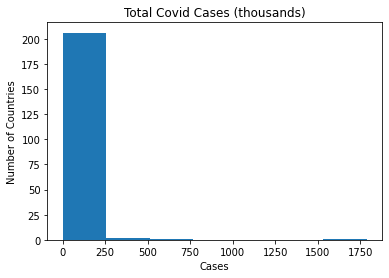

In [44]:
plt.hist(covidtotalsonly['total_cases']/1000, bins=7)
plt.title("Total Covid Cases (thousands)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

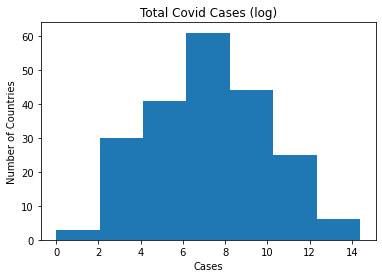

In [43]:
# 로그변환 적용
covidlogs = covidtotalsonly.copy()
for col in covidtotalsonly.columns[1:]:
  covidlogs[col] = np.log1p(covidlogs[col])

plt.hist(covidlogs['total_cases'], bins=7)
plt.title("Total Covid Cases (log)")
plt.xlabel('Cases')
plt.ylabel("Number of Countries")
plt.show()

## 회귀를 이용한 이상값 식별하기
- 데이터를 불러온다. 

In [46]:
# covidtotals = pd.read_csv("data/covidtotals.csv")
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/2022/Python 데이터 분석 라이브러리_20220423/Basic/Chapter 5. Missing Values & Outliers/'
covidtotals = pd.read_csv(DATA_PATH + "data/covidtotals.csv")
covidtotals.set_index("iso_code", inplace=True)

- 추출할 변수들을 설정한다. 

In [47]:
totvars = ['location','total_cases','total_deaths','total_cases_pm','total_deaths_pm']
demovars = ['population','pop_density','median_age','gdp_per_capita','hosp_beds']

- 누적 및 인구통계 열에 대한 상관행렬을 생성
  + 총확진자 수와 총 사망자 수 사이에는 당연하지만 매우 높은 상관관계가 있음. 
  + 백만 명당 총 확진자수와 백만 명당 총 사망자 수 사이도 상당한(0.59) 상관관계 있음. 
  + 1인당 국민소득과 백만 명당 확진자 수 사이에 강한(0.65) 상관관계가 있음. 

In [48]:
covidtotals.corr(method="pearson")

,total_cases,total_deaths,total_cases_pm,...,median_age,gdp_per_capita,hosp_beds
total_cases,1.00,0.93,0.18,...,0.16,0.19,0.03
total_deaths,0.93,1.00,0.18,...,0.21,0.20,0.02
total_cases_pm,0.18,0.18,1.00,...,0.31,0.65,0.08
total_deaths_pm,0.25,0.39,0.59,...,0.39,0.38,0.12
population,0.27,0.21,-0.06,...,0.02,-0.06,-0.04
pop_density,-0.03,-0.03,0.11,...,0.18,0.32,0.31
median_age,0.16,0.21,0.31,...,1.00,0.65,0.66
gdp_per_capita,0.19,0.20,0.65,...,0.65,1.00,0.30
hosp_beds,0.03,0.02,0.08,...,0.66,0.30,1.00


- 총 확진자 수에 비해 총 사망자 수가 예상을 벗어나는 국가가 있는지 확인
- 이 때, qcut을 사용해 데이터를 분위수로 나눈 열을 생성
- 총 사망자 분위별 총확진자 분위수의 크로스탭 표시

In [49]:
covidtotalsonly = covidtotals.loc[:, totvars]
covidtotalsonly['total_cases_q'] = pd.qcut(covidtotalsonly['total_cases'], 
                                           labels=['very low','low','medium','high','very high'], 
                                           q=5, 
                                           precision=0)
covidtotalsonly['total_deaths_q'] = pd.qcut(covidtotalsonly['total_deaths'], 
                                            labels=['very low','low','medium','high','very high'], 
                                            q=5, 
                                            precision=0)

pd.crosstab(covidtotalsonly.total_cases_q, covidtotalsonly.total_deaths_q)

total_deaths_q,very low,low,medium,high,very high
total_cases_q,,,,,
very low,34,7,1,0,0
low,12,19,10,1,0
medium,1,13,15,13,0
high,0,0,12,24,6
very high,0,0,2,4,36


- 대각선에 맞지 않는 국가들을 살펴본다. 
  + 총확진자 수는 매우 높지만, 총사망자수는 중간 
- 확진자 수는 낮으면서 사망자 수가 높은 국

In [50]:
covidtotals.loc[(covidtotalsonly.total_cases_q=="very high") & (covidtotalsonly.total_deaths_q=="medium")].T

iso_code,QAT,SGP
lastdate,2020-06-01,2020-06-01
location,Qatar,Singapore
total_cases,56910,34884
total_deaths,38,23
total_cases_pm,"19,753.15","5,962.73"
total_deaths_pm,13.19,3.93
population,"2,881,060.00","5,850,343.00"
pop_density,227.32,"7,915.73"
median_age,31.90,42.40
gdp_per_capita,"116,935.60","85,535.38"


In [51]:
covidtotals.loc[(covidtotalsonly.total_cases_q=="low") & (covidtotalsonly.total_deaths_q=="high")].T

iso_code,YEM
lastdate,2020-06-01
location,Yemen
total_cases,323
total_deaths,80
total_cases_pm,10.83
total_deaths_pm,2.68
population,"29,825,968.00"
pop_density,53.51
median_age,20.30
gdp_per_capita,"1,479.15"


In [52]:
covidtotals['hosp_beds'].mean()

3.012670731707318

- 총 확진자 수와 총 사망자 수의 산점도 작성 

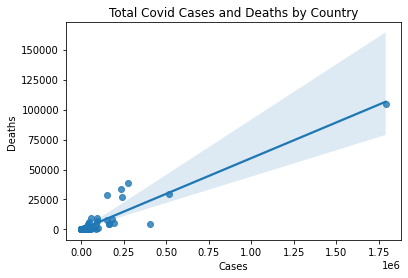

In [53]:
ax = sns.regplot(x="total_cases", y="total_deaths", data=covidtotals)
ax.set(xlabel="Cases", ylabel="Deaths", title="Total Covid Cases and Deaths by Country")
plt.show()

- 회귀직선 위쪽의 예상치 못한 값 조사

In [54]:
covidtotals.loc[(covidtotals.total_cases<300000) & (covidtotals.total_deaths>20000)].T

iso_code,FRA,ITA,ESP,GBR
lastdate,2020-06-01,2020-06-01,2020-05-31,2020-06-01
location,France,Italy,Spain,United Kingdom
total_cases,151753,233019,239429,274762
total_deaths,28802,33415,27127,38489
total_cases_pm,"2,324.88","3,853.99","5,120.95","4,047.40"
total_deaths_pm,441.25,552.66,580.20,566.97
population,"65,273,512.00","60,461,828.00","46,754,783.00","67,886,004.00"
pop_density,122.58,205.86,93.11,272.90
median_age,42.00,47.90,45.50,40.80
gdp_per_capita,"38,605.67","35,220.08","34,272.36","39,753.24"


In [55]:
covidtotals.loc[(covidtotals.total_cases>300000) & (covidtotals.total_deaths<10000)].T

iso_code,RUS
lastdate,2020-06-01
location,Russia
total_cases,405843
total_deaths,4693
total_cases_pm,"2,780.99"
total_deaths_pm,32.16
population,"145,934,460.00"
pop_density,8.82
median_age,39.60
gdp_per_capita,"24,765.95"


- 백만 명당 확진자 수와 사망자 수를 나타내는 산점도를 그린다. 

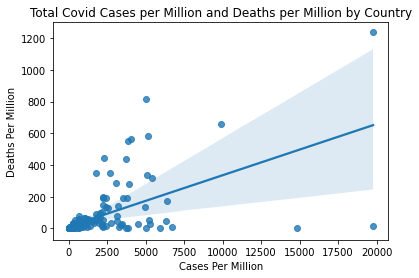

In [56]:
ax = sns.regplot(x="total_cases_pm", y="total_deaths_pm", data=covidtotals)
ax.set(xlabel="Cases Per Million", ylabel="Deaths Per Million", title="Total Covid Cases per Million and Deaths per Million by Country")
plt.show()

- 회귀직선 위쪽에 있는 백만 명당 사망자 수 조사한다. 

In [57]:
covidtotals.loc[(covidtotals.total_cases_pm<7500) \
  & (covidtotals.total_deaths_pm>250),\
  ['location','total_cases_pm','total_deaths_pm']]

,location,total_cases_pm,total_deaths_pm
iso_code,,,
BEL,Belgium,"5,037.35",816.85
FRA,France,"2,324.88",441.25
IRL,Ireland,"5,060.96",334.56
IMN,Isle of Man,"3,951.45",282.25
ITA,Italy,"3,853.99",552.66
JEY,Jersey,"3,047.30",286.92
NLD,Netherlands,"2,710.38",347.60
SXM,Sint Maarten (Dutch part),"1,795.62",349.80
ESP,Spain,"5,120.95",580.20


In [58]:
covidtotals.loc[(covidtotals.total_cases_pm>5000) \
  & (covidtotals.total_deaths_pm<=50), \
  ['location','total_cases_pm','total_deaths_pm']]

,location,total_cases_pm,total_deaths_pm
iso_code,,,
BHR,Bahrain,"6,698.47",11.17
GIB,Gibraltar,"5,016.18",0.00
ISL,Iceland,"5,292.31",29.30
KWT,Kuwait,"6,332.42",49.64
QAT,Qatar,"19,753.15",13.19
SGP,Singapore,"5,962.73",3.93
VAT,Vatican,"14,833.13",0.00
